In [1]:
import tensorflow as tf
import os
import math
import time
import pickle
from PIL import Image
import numpy as np
import cifar10_input
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
CIFAR_DIR = "./cifar-10-batches-py/"
#print (os.listdir(CIFAR_DIR))
#bat_data, bat_labels = cifar10_input.distorted_inputs(data_dir=CIFAR_DIR,batch_size=20)
#print(bat_data)

In [2]:
def load_data(filename):
    """read data from data file."""
    with open(filename,'rb') as f:
        data = pickle.load(f,encoding='bytes')
        #print(data[b'data'][1])
        #print(data.shape)
        return data[b'data'],data[b'labels']
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

    

In [3]:
def sort_image_real(num):
    if num == 1:
        x = '小汽车'
    elif num == 2:
        x = '鸟类'
    elif num == 3:
        x = '猫'
    elif num == 4:
        x = '鹿'
    elif num == 5:
        x = '狗'
    elif num == 6:
        x = '青蛙'
    elif num == 7:
        x = '马'
    elif num == 8:
        x = '船'
    elif num ==9:
        x = '卡车'
    elif num == 0:
        x = '飞机'
    else :
        x = 'error'
    return x
        
    

In [4]:
class CifarData:
    def __init__(self,filenames,need_shuffle):
        all_data = []
        all_labels = []
        
        for filename in filenames:
            data,labels = load_data(filename)
            print(data.shape)
            all_data.append(data)
            
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        #print(all_data[1])
        #print(data[1])
        self._image = self._data
        self._data = self._data / 127.5 -1
        
        self._labels = np.hstack(all_labels)
        '''print (self._data.shape)
        print (self._labels.shape)
        '''
        self._num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def _shuffle_data(self):
        #[0,1,2,3,4,5]-> [5,3,2,4,0,1]
        p = np.random.permutation(self._num_examples)
        self._data = self._data[p]
        self._labels = self._labels[p]
        
    def next_batch(self,batch_size):
        """return batch_size examples as a batch."""
        end_indicator = self._indicator + batch_size
        if end_indicator > self._num_examples:
            if self._need_shuffle:
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception("have no more examples  ")
        if end_indicator > self._num_examples:
            raise Exception("batch size is larger than all examples")
        batch_image = self._image[self._indicator: end_indicator]
        batch_data = self._data[self._indicator: end_indicator]
        #batch_data = self._data[end_indicator]
        #print(self._data[end_indicator])
        #print('######################################')
        #print(self._data[self._indicator: end_indicator])
        #print(batch_data)
        #print(batch_data.shape)
        batch_labels = self._labels[self._indicator: end_indicator]
        #batch_labels = self._labels[end_indicator]
        self._indicator = end_indicator
        return batch_image,batch_data,batch_labels

                            



In [5]:
train_filenames = [os.path.join(CIFAR_DIR, 'data_batch_%d.bin' % i) for i in range(1,6)]
test_filenames = [os.path.join(CIFAR_DIR, 'test_batch.bin')]

train_data = CifarData(train_filenames,True)
test_data = CifarData(test_filenames,False)

(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)
(10000, 3072)


In [6]:
'''
# (3072,10)
w = tf.get_variable('w',[x.get_shape()[-1], 10],
                    initializer = tf.random_normal_initializer(0, 1))
#(10, )
b = tf.get_variable('b',[10],
                    initializer = tf.constant_initializer(0.0))

# [None,3072]*[3072,10] = [None,10]
y_ = tf.matmul(x,w) + b
'''
# (3072,10)
#W_conv1 = variable_with_weight_loss(shape=[5, 5, 3, 64], stddev=5e-2, w1=0.0)

#(10, )
#b_conv1 = tf.Variable(tf.constant(0.0, shape=[64]))
batch_size = 20

x = tf.placeholder(tf.float32,[None,3072])
x_image = tf.reshape(x, [batch_size,32,32,3])
#[None]
y = tf.placeholder(tf.int64,[None])
#[CONV->POOL]
W_conv1_1 = weight_variable([3, 3, 3, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, W_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)
norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
#[CONVx2->POOL]
W_conv2= weight_variable([3, 3, 64, 64])
b_conv2 = bias_variable([64])
h_conv2_1 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2_2)
norm2 = tf.nn.lrn(h_pool2, 4, bias=1.0, alpha=0.001/0.9, beta=0.75)
#[CONVx2->POOL]
W_conv3_1= weight_variable([3, 3, 64, 128])
b_conv3_1 = bias_variable([128])
h_conv3_1 = tf.nn.relu(conv2d(norm2, W_conv3_1) + b_conv3_1)   
W_conv3_2= weight_variable([3, 3, 128, 128])
b_conv3_2 = bias_variable([128])
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, W_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)
norm3 = tf.nn.lrn(h_pool3, 4, bias=1.0, alpha=0.001/0.9, beta=0.75)


norm3_flat = tf.reshape(norm3, [batch_size, -1])
dim = norm3_flat.get_shape()[1].value
print(dim)
W_fc1 = weight_variable([dim,1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(norm3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 512])
b_fc2 = bias_variable([512])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

W_fc3 = weight_variable([512, 10])
b_fc3 = bias_variable([10])
y_ = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
#y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
print(x_image)
print(y_)
'''

#
p_y = vgg.forward(images)
#5 -> [0,0,0,0,0,1,0,0,0,0]
y_one_hot = tf.one_hot(y,10,dtype=tf.float32)
loss = tf.reduce_mean(tf.square(y_one_hot - p_y))
'''


loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
#y_ -> sofmax
#y -> one_hot
#loss = ylogy_
#bool
image_prediction = tf.argmax(y_,1)
# [1,#0,1,1,1,0,0,0]
correct_prediction = tf.equal(image_prediction,y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float64))
top_k_op = tf.nn.in_top_k(y_, y, 1)
with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.
2048
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("Reshape:0", shape=(20, 32, 32, 3), dtype=float32)
Tensor("add_7:0", shape=(20, 10), dtype=float32)
Instructions for updating:
Use tf.cast instead.


step 100, loss=2.32 (181.5 examples/sec; 0.110 sec/batch),acc: 0.15000
step 200, loss=2.17 (184.1 examples/sec; 0.109 sec/batch),acc: 0.20000
step 300, loss=2.38 (184.5 examples/sec; 0.108 sec/batch),acc: 0.15000
step 400, loss=2.39 (184.4 examples/sec; 0.108 sec/batch),acc: 0.10000
step 500, loss=1.64 (181.6 examples/sec; 0.110 sec/batch),acc: 0.45000
step 600, loss=2.92 (185.3 examples/sec; 0.108 sec/batch),acc: 0.15000
step 700, loss=2.21 (183.9 examples/sec; 0.109 sec/batch),acc: 0.20000
step 800, loss=2.09 (183.7 examples/sec; 0.109 sec/batch),acc: 0.25000
step 900, loss=2.05 (180.0 examples/sec; 0.111 sec/batch),acc: 0.30000
step 1000, loss=2.09 (183.4 examples/sec; 0.109 sec/batch),acc: 0.45000
step 1100, loss=1.77 (182.6 examples/sec; 0.110 sec/batch),acc: 0.30000
step 1200, loss=1.84 (183.7 examples/sec; 0.109 sec/batch),acc: 0.30000
step 1300, loss=2.14 (184.1 examples/sec; 0.109 sec/batch),acc: 0.45000
step 1400, loss=1.84 (182.5 examples/sec; 0.110 sec/batch),acc: 0.40000
s

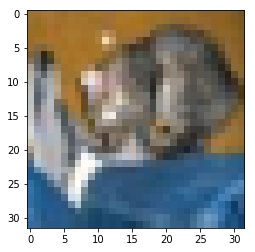

[Test] Step:1 预测分类是 青蛙，真实分类是 猫


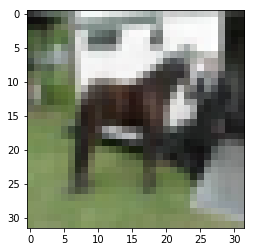

[Test] Step:2 预测分类是 猫，真实分类是 马


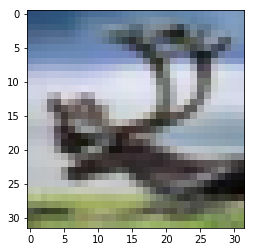

[Test] Step:3 预测分类是 小汽车，真实分类是 鹿


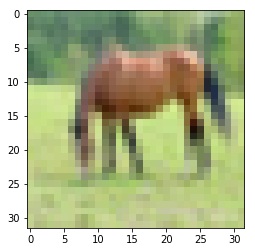

[Test] Step:4 预测分类是 马，真实分类是 马


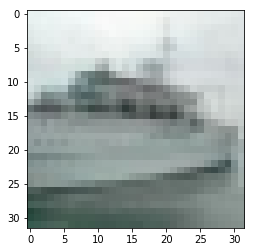

[Test] Step:5 预测分类是 船，真实分类是 船


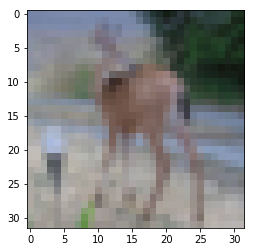

[Test] Step:6 预测分类是 狗，真实分类是 鹿


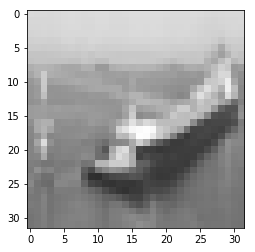

[Test] Step:7 预测分类是 飞机，真实分类是 船


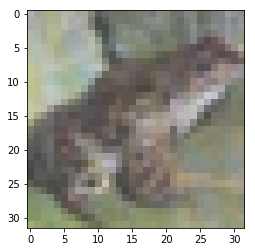

[Test] Step:8 预测分类是 青蛙，真实分类是 青蛙


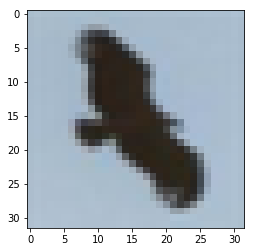

[Test] Step:9 预测分类是 飞机，真实分类是 鸟类


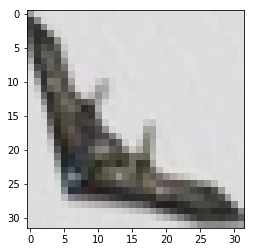

[Test] Step:10 预测分类是 小汽车，真实分类是 飞机


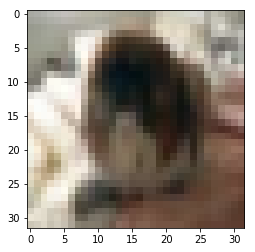

[Test] Step:11 预测分类是 猫，真实分类是 狗


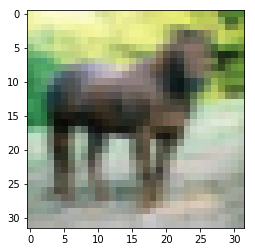

[Test] Step:12 预测分类是 马，真实分类是 马


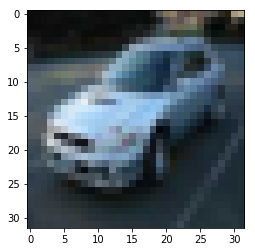

[Test] Step:13 预测分类是 小汽车，真实分类是 小汽车


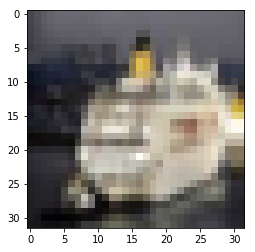

[Test] Step:14 预测分类是 猫，真实分类是 船


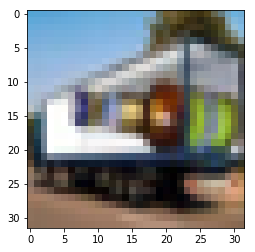

[Test] Step:15 预测分类是 卡车，真实分类是 卡车


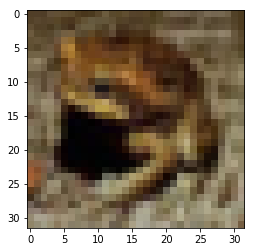

[Test] Step:16 预测分类是 青蛙，真实分类是 青蛙


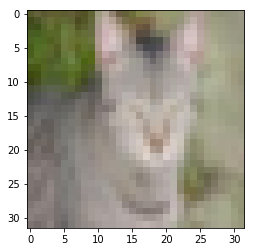

[Test] Step:17 预测分类是 狗，真实分类是 猫


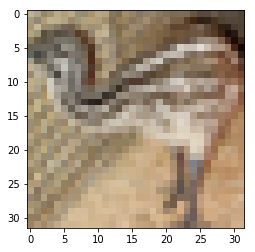

[Test] Step:18 预测分类是 狗，真实分类是 鸟类


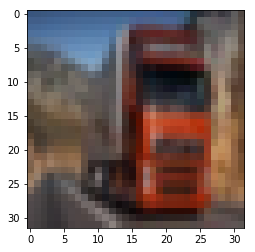

[Test] Step:19 预测分类是 卡车，真实分类是 卡车


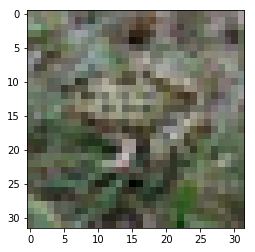

[Test] Step:20 预测分类是 青蛙，真实分类是 青蛙


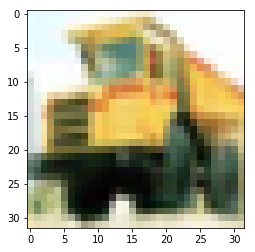

[Test] Step:21 预测分类是 青蛙，真实分类是 卡车


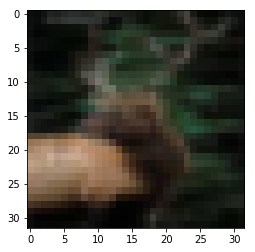

[Test] Step:22 预测分类是 鹿，真实分类是 鹿


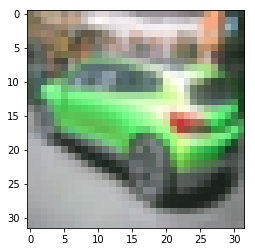

[Test] Step:23 预测分类是 小汽车，真实分类是 小汽车


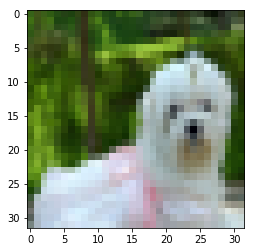

[Test] Step:24 预测分类是 狗，真实分类是 狗


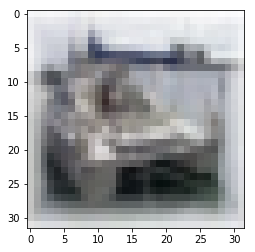

[Test] Step:25 预测分类是 小汽车，真实分类是 船


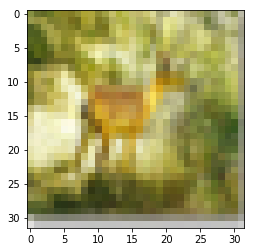

[Test] Step:26 预测分类是 鹿，真实分类是 鹿


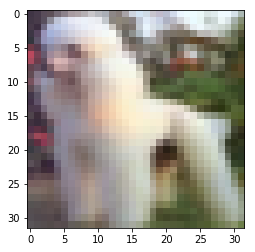

[Test] Step:27 预测分类是 狗，真实分类是 狗


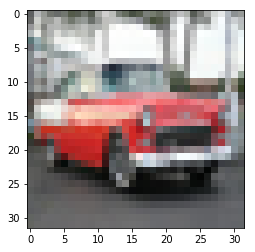

[Test] Step:28 预测分类是 小汽车，真实分类是 小汽车


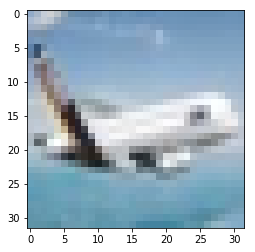

[Test] Step:29 预测分类是 飞机，真实分类是 飞机


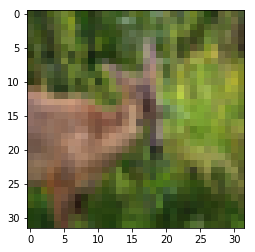

[Test] Step:30 预测分类是 鹿，真实分类是 鹿


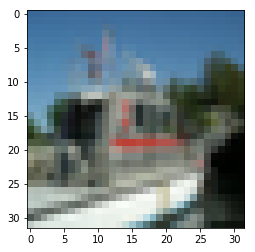

[Test] Step:31 预测分类是 猫，真实分类是 船


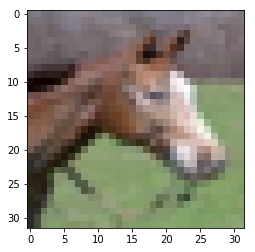

[Test] Step:32 预测分类是 狗，真实分类是 马


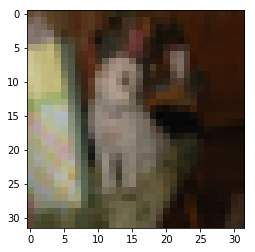

[Test] Step:33 预测分类是 猫，真实分类是 狗


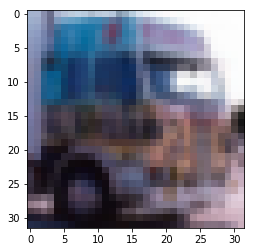

[Test] Step:34 预测分类是 小汽车，真实分类是 卡车


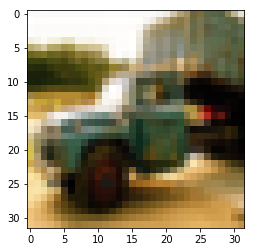

[Test] Step:35 预测分类是 小汽车，真实分类是 卡车


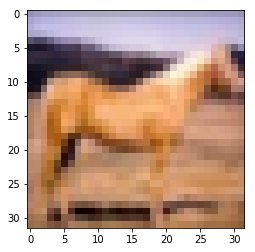

[Test] Step:36 预测分类是 马，真实分类是 马


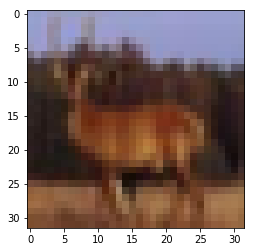

[Test] Step:37 预测分类是 马，真实分类是 鹿


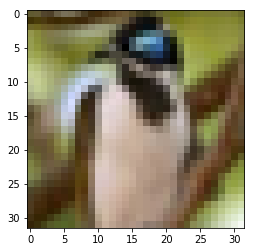

[Test] Step:38 预测分类是 狗，真实分类是 鸟类


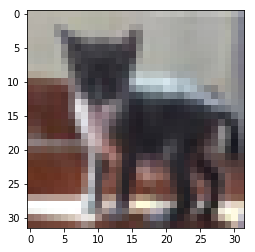

[Test] Step:39 预测分类是 卡车，真实分类是 猫


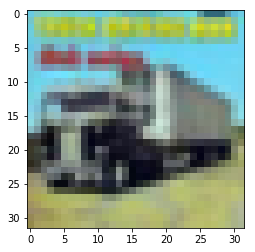

[Test] Step:40 预测分类是 小汽车，真实分类是 卡车


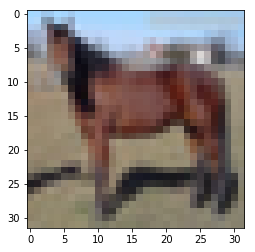

[Test] Step:41 预测分类是 马，真实分类是 马


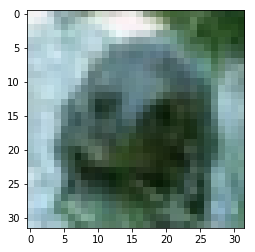

[Test] Step:42 预测分类是 青蛙，真实分类是 青蛙


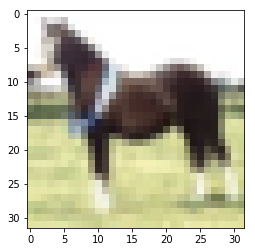

[Test] Step:43 预测分类是 马，真实分类是 马


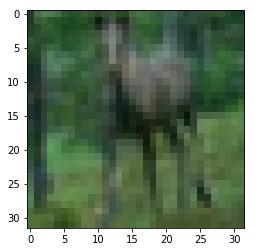

[Test] Step:44 预测分类是 鹿，真实分类是 鹿


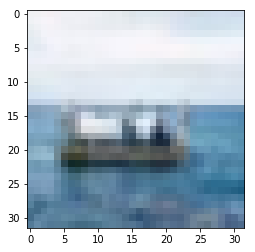

[Test] Step:45 预测分类是 船，真实分类是 船


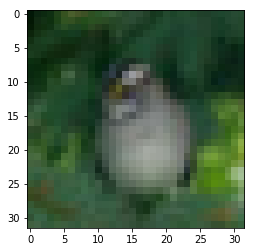

[Test] Step:46 预测分类是 鹿，真实分类是 鸟类


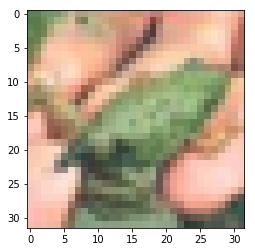

[Test] Step:47 预测分类是 青蛙，真实分类是 青蛙


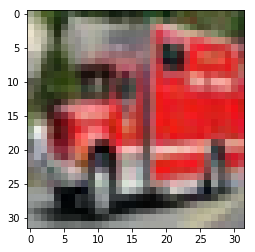

[Test] Step:48 预测分类是 小汽车，真实分类是 卡车


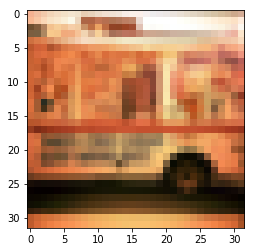

[Test] Step:49 预测分类是 卡车，真实分类是 卡车


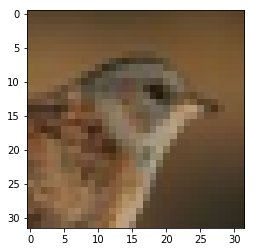

[Test] Step:50 预测分类是 青蛙，真实分类是 鸟类


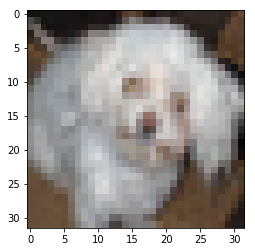

[Test] Step:51 预测分类是 狗，真实分类是 狗


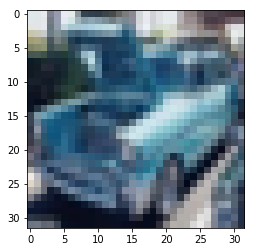

[Test] Step:52 预测分类是 小汽车，真实分类是 小汽车


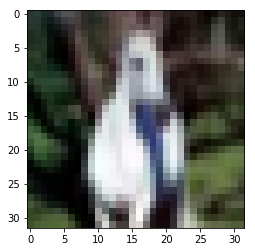

[Test] Step:53 预测分类是 狗，真实分类是 马


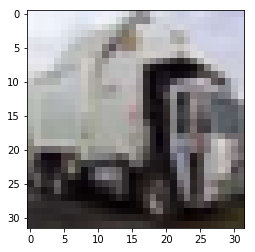

[Test] Step:54 预测分类是 卡车，真实分类是 卡车


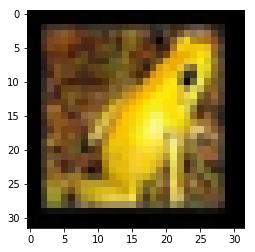

[Test] Step:55 预测分类是 青蛙，真实分类是 青蛙


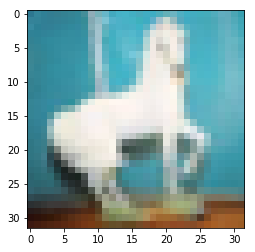

[Test] Step:56 预测分类是 船，真实分类是 马


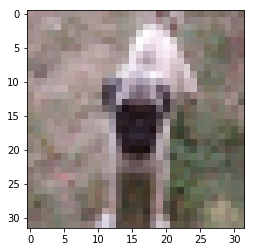

[Test] Step:57 预测分类是 鸟类，真实分类是 狗


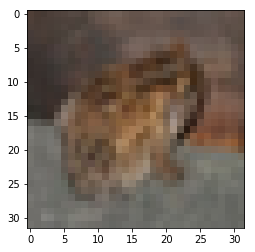

[Test] Step:58 预测分类是 青蛙，真实分类是 青蛙


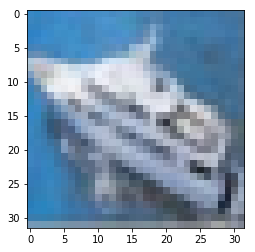

[Test] Step:59 预测分类是 船，真实分类是 船


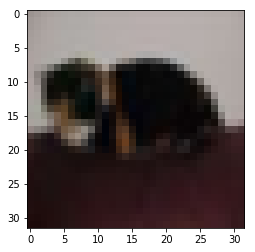

[Test] Step:60 预测分类是 猫，真实分类是 猫


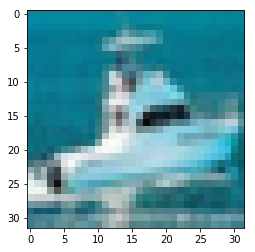

[Test] Step:61 预测分类是 船，真实分类是 船


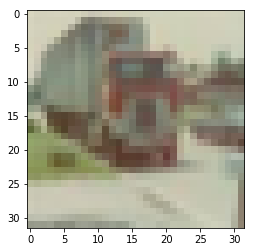

[Test] Step:62 预测分类是 青蛙，真实分类是 卡车


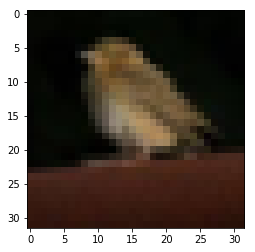

[Test] Step:63 预测分类是 青蛙，真实分类是 鸟类


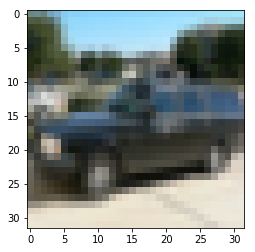

[Test] Step:64 预测分类是 小汽车，真实分类是 小汽车


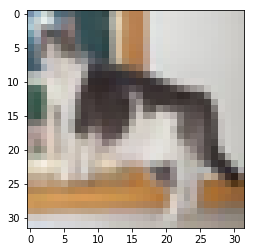

[Test] Step:65 预测分类是 狗，真实分类是 猫


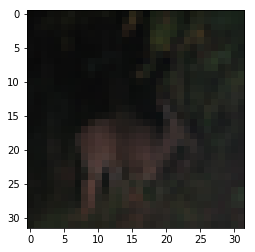

[Test] Step:66 预测分类是 鹿，真实分类是 鹿


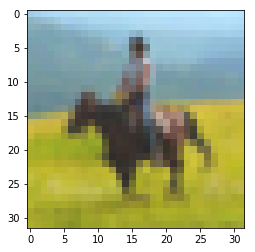

[Test] Step:67 预测分类是 马，真实分类是 马


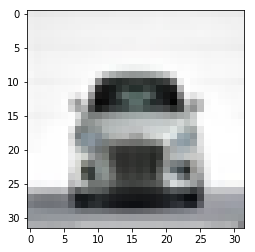

[Test] Step:68 预测分类是 小汽车，真实分类是 小汽车


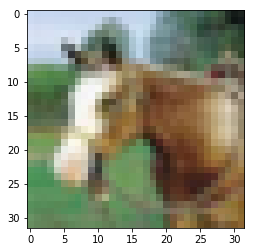

[Test] Step:69 预测分类是 狗，真实分类是 马


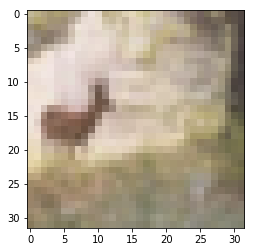

[Test] Step:70 预测分类是 青蛙，真实分类是 鹿


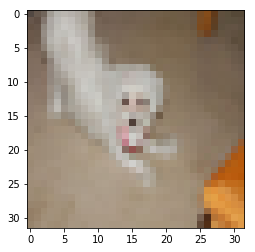

[Test] Step:71 预测分类是 狗，真实分类是 狗


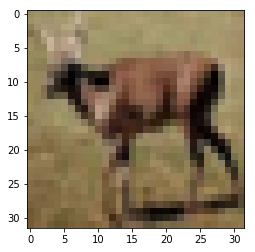

[Test] Step:72 预测分类是 鹿，真实分类是 鹿


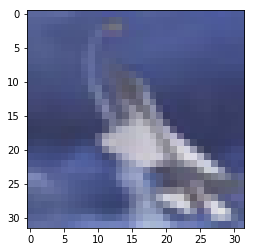

[Test] Step:73 预测分类是 船，真实分类是 飞机


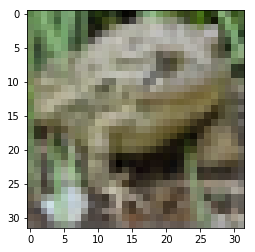

[Test] Step:74 预测分类是 青蛙，真实分类是 青蛙


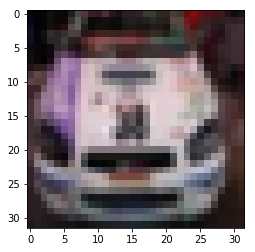

[Test] Step:75 预测分类是 猫，真实分类是 小汽车


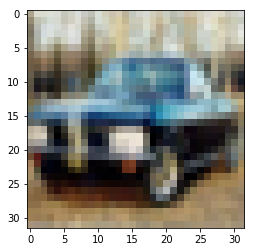

[Test] Step:76 预测分类是 小汽车，真实分类是 小汽车


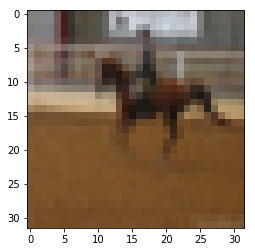

[Test] Step:77 预测分类是 马，真实分类是 马


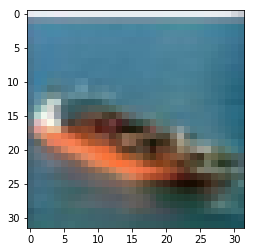

[Test] Step:78 预测分类是 船，真实分类是 船


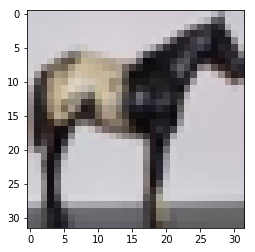

[Test] Step:79 预测分类是 马，真实分类是 马


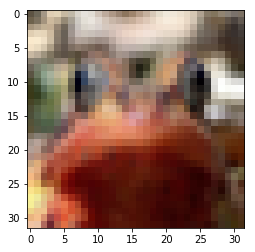

[Test] Step:80 预测分类是 小汽车，真实分类是 青蛙


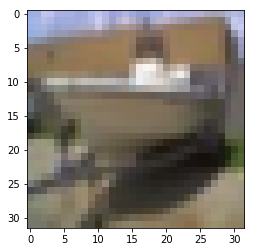

[Test] Step:81 预测分类是 小汽车，真实分类是 船


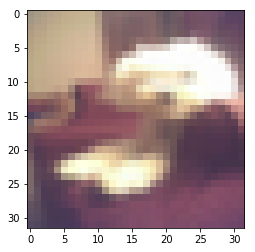

[Test] Step:82 预测分类是 船，真实分类是 狗


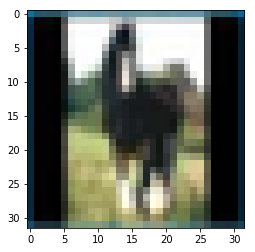

[Test] Step:83 预测分类是 狗，真实分类是 马


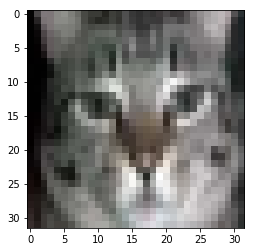

[Test] Step:84 预测分类是 狗，真实分类是 猫


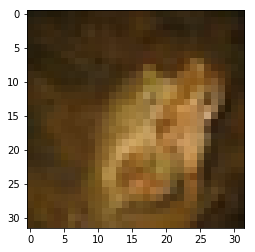

[Test] Step:85 预测分类是 鹿，真实分类是 青蛙


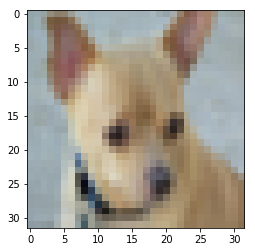

[Test] Step:86 预测分类是 鸟类，真实分类是 狗


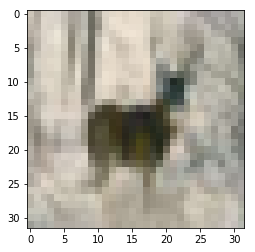

[Test] Step:87 预测分类是 鹿，真实分类是 鹿


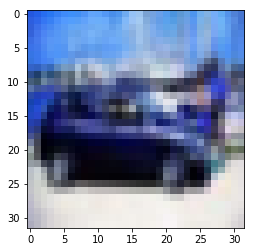

[Test] Step:88 预测分类是 小汽车，真实分类是 小汽车


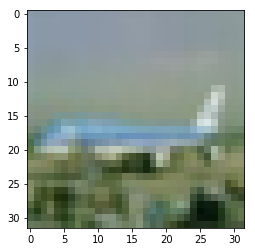

[Test] Step:89 预测分类是 飞机，真实分类是 飞机


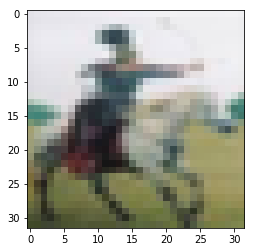

[Test] Step:90 预测分类是 马，真实分类是 马


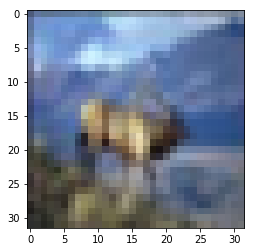

[Test] Step:91 预测分类是 鹿，真实分类是 鹿


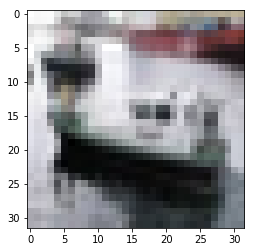

[Test] Step:92 预测分类是 小汽车，真实分类是 船


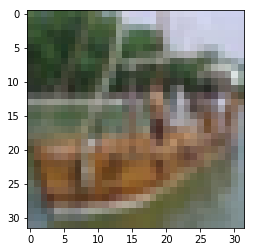

[Test] Step:93 预测分类是 猫，真实分类是 船


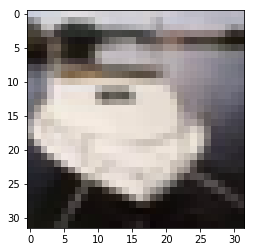

[Test] Step:94 预测分类是 卡车，真实分类是 船


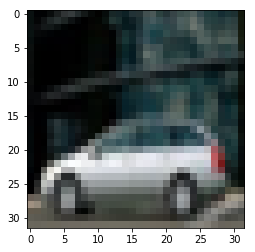

[Test] Step:95 预测分类是 小汽车，真实分类是 小汽车


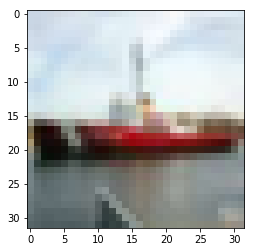

[Test] Step:96 预测分类是 船，真实分类是 船


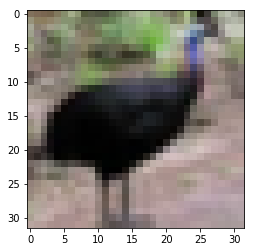

[Test] Step:97 预测分类是 鸟类，真实分类是 鸟类


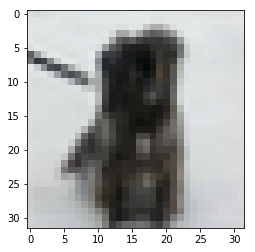

[Test] Step:98 预测分类是 猫，真实分类是 狗


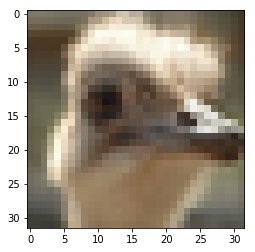

[Test] Step:99 预测分类是 狗，真实分类是 鸟类


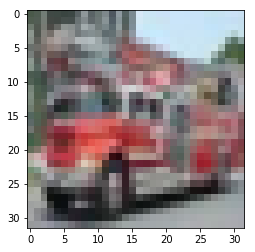

[Test] Step:100 预测分类是 小汽车，真实分类是 卡车
 acc: 0.53600


In [7]:
init = tf.global_variables_initializer()
train_steps = 10000
test_steps = 100
#test_batch_data, test_batch_labels = cifar10_input.inputs(eval_data=True, data_dir=CIFAR_DIR, batch_size=batch_size)
with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        start_time = time.time()
        #batch_data, batch_labels = cifar10_input.distorted_inputs(data_dir=CIFAR_DIR,batch_size=batch_size)
        batch_image,batch_data, batch_labels = train_data.next_batch(batch_size)
        loss_val, acc_val,_ = sess.run(
            [loss,accuracy,train_op],feed_dict={
                x: batch_data,y: batch_labels,keep_prob:0.5})
        duration = time.time() - start_time
        if (i+1) % 100 == 0:
            examples_per_sec = batch_size / duration
            sec_per_batch = float(duration)
            format_str = ('step %d, loss=%.2f (%.1f examples/sec; %.3f sec/batch),acc: %4.5f')
            print(format_str % (i+1, loss_val, examples_per_sec, sec_per_batch,acc_val))
    all_test_acc_val = []
    for j in range(test_steps):
        test_batch_image,test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)
        #print(test_batch_data.shape)
        
        test_acc_val = sess.run(accuracy,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        sort_prediction = sess.run(
            image_prediction,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        sort_real = sess.run(
            y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        
        image= test_batch_image[0].reshape((3,32,32)) #32 32 3
        image = image.transpose((1,2,0))
        plt.imshow(image)
        plt.show()
        #sort_prediction = tf.nn.top_k(sort_prediction,1)
        #sort_real = tf.nn.top_k(sort_real,1)
        print('[Test] Step:%d 预测分类是 %s，真实分类是 %s'% 
              (j+1 ,sort_image_real(sort_prediction[0]),sort_image_real(sort_real[0])))
        all_test_acc_val.append(test_acc_val)
    test_acc = np.mean(all_test_acc_val)
    print(' acc: %4.5f'% (test_acc))
        
 

In [8]:
   
"""    
   all_test_acc_val = []
    for j in range(test_steps):
        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)
        test_acc_val = sess.run(accuracy,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        #image_prediction = sess.run(y_,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        #image_real = sess.run(y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        #image_prediction = tf.nn.top_k(image_prediction,1)
        #image_real = tf.nn.top_k(image_real,1)        
        all_test_acc_val.append(test_acc_val)
    test_acc = np.mean(all_test_acc_val)
    #print('[Test] Step:%d 真实分类是 %s，预测分类是 %s, acc: %4.5f'% (i+1 ,image_prediction.values,image_real.values,test_acc))
    print('[Test] Step:%d , acc: %4.5f'% (i+1 ,test_acc))
     
"""    


"    \nall_test_acc_val = []\n for j in range(test_steps):\n     test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)\n     test_acc_val = sess.run(accuracy,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n     #image_prediction = sess.run(y_,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n     #image_real = sess.run(y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n     #image_prediction = tf.nn.top_k(image_prediction,1)\n     #image_real = tf.nn.top_k(image_real,1)        \n     all_test_acc_val.append(test_acc_val)\n test_acc = np.mean(all_test_acc_val)\n #print('[Test] Step:%d 真实分类是 %s，预测分类是 %s, acc: %4.5f'% (i+1 ,image_prediction.values,image_real.values,test_acc))\n print('[Test] Step:%d , acc: %4.5f'% (i+1 ,test_acc))\n  \n"

In [9]:
"""
num_examples = 300
    all_test_acc_val = []
    num_inter = int(math.ceil(num_examples / batch_size))
    true_count = 0   
    total_sample_count = num_inter * batch_size
    step = 0
    while step < num_inter:
        #test_batch_data, test_batch_labels= sess.run([test_batch_data, test_batch_labels]   ) 
        #test_batch_data = tf.reshape(test_batch_data,[20,1728]
        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)
        test_acc_val,count_pred_true =sess.run(
            [accuracy,top_k_op],
            feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        sort_prediction = sess.run(
            image_prediction,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        sort_real = sess.run(
            y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})
        true_count += np.sum(count_pred_true)
        #print(image_real)
        #print(sess.run(image_prediction.indices))
        sort_prediction = tf.nn.top_k(sort_prediction,1)
        sort_real = tf.nn.top_k(sort_real,1)
        print('[Test] Step:%d 预测分类是 %s，真实分类是 %s'% 
              (step ,sess.run(sort_prediction.indices),sess.run(sort_real.indices)))
        step += 1
    prediction = true_count / total_sample_count
    print ('precision @ 1 = %.3f,acc: %4.5f '
           % (prediction,test_acc_val))
"""

"\nnum_examples = 300\n    all_test_acc_val = []\n    num_inter = int(math.ceil(num_examples / batch_size))\n    true_count = 0   \n    total_sample_count = num_inter * batch_size\n    step = 0\n    while step < num_inter:\n        #test_batch_data, test_batch_labels= sess.run([test_batch_data, test_batch_labels]   ) \n        #test_batch_data = tf.reshape(test_batch_data,[20,1728]\n        test_batch_data, test_batch_labels  = test_data.next_batch(batch_size)\n        test_acc_val,count_pred_true =sess.run(\n            [accuracy,top_k_op],\n            feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        sort_prediction = sess.run(\n            image_prediction,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        sort_real = sess.run(\n            y,feed_dict = {x: test_batch_data,y: test_batch_labels,keep_prob:1.0})\n        true_count += np.sum(count_pred_true)\n        #print(image_real)\n        #print(sess.run(image_prediction.in